<a href="https://colab.research.google.com/github/vadim-privalov/Sorevnovania/blob/main/%D0%9F%D1%88%D0%B5%D0%BD%D0%B8%D1%86%D0%B0_%D0%BE%D0%B1%D0%BD%D0%B0%D1%80%D1%83%D0%B6%D0%B5%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/albumentations-team/albumentations.git

  Cloning https://github.com/albumentations-team/albumentations.git to /tmp/pip-req-build-gyg3dx77
  Running command git clone -q https://github.com/albumentations-team/albumentations.git /tmp/pip-req-build-gyg3dx77
     |████████████████████████████████| 47.8 MB 1.6 MB/s 
  Created wheel for albumentations: filename=albumentations-1.1.0-py3-none-any.whl size=112723 sha256=8704f76bd16dc03e1c161196cb8aae19de3573e23c43818868bd61d0a902d49b
  Stored in directory: /tmp/pip-ephem-wheel-cache-gkv67zmm/wheels/09/5b/e0/38cb85186b3cb979092395de69893163f9a223a72066123599
Successfully built albumentations
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [ ]:
!pip install "opencv-python-headless<4.3"

     |████████████████████████████████| 21.6 MB 1.5 MB/s 
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.5.5.64
    Uninstalling opencv-python-headless-4.5.5.64:
      Successfully uninstalled opencv-python-headless-4.5.5.64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import albumentations as A
from albumentations.pytorch import ToTensorV2 
import torchvision
from torchvision import datasets,transforms
from tqdm import tqdm
import cv2
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
from PIL import Image
import os
import torch.nn.functional as F
import ast

In [ ]:
!ls '/content/drive/MyDrive/my_databases/global-wheat-detection'

sample_submission.csv  test  train  train.csv


In [ ]:
# config
LR = 1e-4
SPLIT = 0.2
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 4
EPOCHS = 2
DATAPATH = '/content/drive/MyDrive/my_databases/global-wheat-detection'

In [ ]:
df = pd.read_csv(DATAPATH + '/train.csv')
df.bbox = df.bbox.apply(ast.literal_eval)

In [ ]:
df = df.groupby("image_id")["bbox"].apply(list).reset_index(name="bboxes")

In [ ]:
def train_test_split(dataFrame,split):
    len_tot = len(dataFrame)
    val_len = int(split*len_tot)
    train_len = len_tot-val_len
    train_data,val_data = dataFrame.iloc[:train_len][:],dataFrame.iloc[train_len:][:]
    return train_data,val_data

In [ ]:
train_data_df,val_data_df = train_test_split(df,SPLIT)

In [ ]:
train_data_df

,image_id,bboxes
0,00333207f,"[[0, 654, 37, 111], [0, 817, 135, 98], [0, 192..."
1,005b0d8bb,"[[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15..."
2,006a994f7,"[[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11..."
3,00764ad5d,"[[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1..."
4,00b5fefed,"[[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1..."
...,...,...
2694,cbfaa3ed9,"[[532.0, 929.0, 138.0, 74.0], [194.0, 491.0, 8..."
2695,cbfd50139,"[[3, 84, 117, 99], [96, 1, 87, 80], [0, 177, 5..."
2696,cc1a14dfc,"[[622.0, 494.0, 125.0, 122.0], [836.0, 316.0, ..."
2697,cc236443b,"[[643.0, 13.0, 69.0, 77.0], [356.0, 88.0, 82.0..."


In [ ]:
class WheatDataset(Dataset):
    def __init__(self,data,root_dir,transform=None,train=True):
        self.data = data
        self.root_dir = root_dir
        self.image_names = self.data.image_id.values
        self.bboxes = self.data.bboxes.values
        self.transform = transform
        self.isTrain = train
    def __len__(self):
        return len(self.data)
    def __getitem__(self,index):
#         print(self.image_names)
#         print(self.bboxes)
        img_path = os.path.join(self.root_dir,self.image_names[index]+".jpg")
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        bboxes = torch.tensor(self.bboxes[index],dtype=torch.float64)
#         print(bboxes)
        """
            As per the docs of torchvision
            we need bboxes in format (xmin,ymin,xmax,ymax)
            Currently we have them in format (xmin,ymin,width,height)
        """
        bboxes[:,2] = bboxes[:,0]+bboxes[:,2]
        bboxes[:,3] = bboxes[:,1]+bboxes[:,3]
#         print(image.size,type(image))
        """
            we need to return image and a target dictionary
            target:
                boxes,labels,image_id,area,iscrowd
        """
        area = (bboxes[:,3]-bboxes[:,1])*(bboxes[:,2]-bboxes[:,0])
        area = torch.as_tensor(area,dtype=torch.float32)
        
        # there is only one class
        labels = torch.ones((len(bboxes),),dtype=torch.int64)
        
        # suppose all instances are not crowded
        iscrowd = torch.zeros((len(bboxes),),dtype=torch.int64)
        
        target = {}
        target['boxes'] = bboxes
        target['labels']= labels
        target['image_id'] = torch.tensor([index])
        target["area"] = area
        target['iscrowd'] = iscrowd
        
        if self.transform is not None:
            sample = {
                'image': image,
                'bboxes': target['boxes'],
                'labels': labels
            }
            sample = self.transform(**sample)
            image = sample['image']
            
            target['boxes'] = torch.stack(tuple(map(torch.tensor, zip(*sample['bboxes'])))).permute(1, 0)
            
        return image,target

In [ ]:
train_transform = A.Compose([
    A.Flip(0.5),
    ToTensorV2(p=1.0)
],bbox_params = {'format':"pascal_voc",'label_fields': ['labels']})
val_transform = A.Compose([
      ToTensorV2(p=1.0)
],bbox_params = {'format':"pascal_voc","label_fields":['labels']})

In [ ]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [ ]:
train_data = WheatDataset(train_data_df,DATAPATH+"/train",transform=train_transform)
valid_data = WheatDataset(val_data_df,DATAPATH+"/train",transform=val_transform)

In [ ]:
image,target = train_data.__getitem__(0)
# plt.imshow(image)
print(image.shape)

torch.Size([3, 1024, 1024])


In [ ]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features,num_classes)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [ ]:
class Averager:
    def __init__(self):
        self.current_total=0.0
        self.iterations = 0.0
    def send(self,value):
        self.current_total+=value
        self.iterations+=1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0*self.current_total/self.iterations
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [ ]:
train_dataloader = DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True,collate_fn=collate_fn)
val_dataloader = DataLoader(valid_data,batch_size=BATCH_SIZE,shuffle=False,collate_fn=collate_fn)

In [ ]:
train_loss = []
# val_loss = []
model = model.to(DEVICE)
params =[p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params,lr=LR)
loss_hist = Averager()
itr = 1
lr_scheduler=None

In [ ]:
loss_hist = Averager()
itr = 1

for epoch in range(EPOCHS):
    loss_hist.reset()
    
    for images, targets in train_dataloader:
        
        images = list(image.to(DEVICE) for image in images)
        targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()

        loss_hist.send(loss_value)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if itr % 50 == 0:
            print(f"Iteration #{itr} loss: {loss_value}")

        itr += 1
    
    # update the learning rate
    if lr_scheduler is not None:
        lr_scheduler.step()

    print(f"Epoch #{epoch} loss: {loss_hist.value}")  


/usr/local/lib/python3.7/dist-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iteration #50 loss: 0.8313622454439628
Iteration #100 loss: 0.9873671895064189
Iteration #150 loss: 0.9331626953808955
Iteration #200 loss: 0.8800656537729628
Iteration #250 loss: 0.9294036866484828
Iteration #300 loss: 0.5544487158688236
Iteration #350 loss: 0.8838564844881952
Iteration #400 loss: 0.7521377801646912
Iteration #450 loss: 0.75369086636566
Iteration #500 loss: 0.7139329551185719
Iteration #550 loss: 0.7869991737132915
Iteration #600 loss: 0.8339994865167656
Iteration #650 loss: 0.8103070933762346
Epoch #0 loss: 0.9059517252762331
Iteration #700 loss: 0.9060089611995108
Iteration #750 loss: 1.0086820033035435
Iteration #800 loss: 0.8671539213032838
Iteration #850 loss: 0.878187013614326
Iteration #900 loss: 0.8206327065843587
Iteration #950 loss: 0.7162474764292966
Iteration #1000 loss: 0.9417810024644887
Iteration #1050 loss: 0.8372955490272005
Iteration #1100 loss: 0.5833677229442042
Iteration #1150 loss: 0.5999067216355196
Iteration #1200 loss: 0.8531237084835798
Itera

In [ ]:
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')

In [ ]:
images, targets = next(iter(val_dataloader))
images = list(img.to(DEVICE) for img in images)
# print(images[0].shape)
targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
boxes = targets[1]['boxes'].cpu().numpy().astype(np.int32)
sample = images[1].permute(1,2,0).cpu().numpy()

In [ ]:
model.eval()
cpu_device = torch.device("cpu")
# print(images[0].shape)
outputs = model(images)
outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
# print(outputs)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


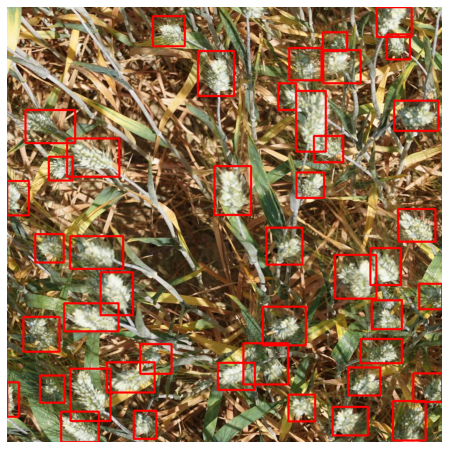

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 8))

for box in boxes:
    cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2], box[3]),
                  (220, 0, 0), 3)
    
ax.set_axis_off()
ax.imshow(sample)

In [ ]:
test_imgs_paths = pd.read_csv(os.path.join(DATAPATH,'sample_submission.csv'))
test_img_paths = test_imgs_paths.image_id.values
test_dir = DATAPATH+"/test"

In [ ]:
predictions=[]
image_ids=[]
with torch.no_grad():
    for path in test_img_paths:
        img_path = os.path.join(test_dir,path+".jpg")
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0
        image = np.transpose(image,(2,0,1))
    #     print(image.shape)
        image = torch.tensor(image,dtype=torch.float)
        image = image.unsqueeze(0)
    #     print(image.shape)
        image = image.to(DEVICE)
        outputs = model(image)

        predict=[]
        outputs = outputs[0]
        for i in range(len(outputs['boxes'])):
            temp = np.array([str(outputs['scores'][i].item()),str(outputs['boxes'][i][0].item()),str(outputs['boxes'][i][1].item()),str(outputs['boxes'][i][2].item()-outputs['boxes'][i][0].item()),str(outputs['boxes'][i][3].item()-outputs['boxes'][i][1].item())])
            predict.append(temp)
        predict = np.array(predict).flatten()
        predict = ' '.join(predict.flatten())
        image_ids.append(path)
        predictions.append(predict)
    print("------------Generating Submission File---------")
    df = pd.DataFrame({"image_id":image_ids,"PredictionString":predictions})
    df.to_csv('./submission.csv.gz',index=False,compression='gzip')


------------Generating Submission File---------
